In [ ]:
!pip install torcheval
!pip install torch_optimizer
!pip install torchmetrics
!pip install torchvision
!pip install lion-pytorch
!pip install timm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import cv2
import random
import numpy as np
import torchvision
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn


from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm

from torch.optim.optimizer import Optimizer
from lion_pytorch import Lion
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingWarmRestarts, SequentialLR

from torch.cuda.amp import autocast, GradScaler
from torchmetrics import F1Score
from timm.data.mixup import Mixup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [ ]:
class HISTEq:
    def __call__(self, img):
      img_np = np.array(img)
      if img_np.dtype != np.uint8:
         img_np = (img_np * 255).astype(np.uint8)

     equalized = cv2.equalizeHist(img_np)

     return transforms.functional.to_pil_image(equalized)




In [ ]:


transform_for_stats = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    HISTEq(),
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])



stats_dataset = datasets.EMNIST(
    root="data",
    split="balanced",
    train=True,
    download=True,
    transform=transform_for_stats
)

stats_loader = DataLoader(
    stats_dataset,
    batch_size=256,
    num_workers=2,
    shuffle=False
)


mean_sum    = 0.0
sq_mean_sum = 0.0
num_pixels  = 0

for images, _ in stats_loader:

    images = images.to(torch.float32)


    mean_sum    += images.sum(dim=[0, 2, 3])
    sq_mean_sum += (images ** 2).sum(dim=[0, 2, 3])

    num_pixels += images.size(0) * images.size(2) * images.size(3)


mean = mean_sum / num_pixels
var  = (sq_mean_sum / num_pixels) - (mean ** 2)
std  = torch.sqrt(var)

print("Mean_value:", mean)
print("Std_value :", std)




100%|██████████| 562M/562M [00:04<00:00, 140MB/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
Mean: tensor([0.1716])
Std : tensor([0.2850])


In [ ]:


mean_value = mean
std_value  = std

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    HISTEq(),
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=2, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_value, std=std_value)
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    HISTEq(),
    transforms.Resize((112, 112)),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean_value, std=std_value)
])








In [ ]:
def data_loaders():


  train_dataset = datasets.EMNIST(root="data", split="balanced", train=True, transform=train_transform, download=True)
  test_dataset = datasets.EMNIST(root="data", split="balanced", train=False, transform= test_transform, download=True)


  train_loader = DataLoader(
        train_dataset,
        batch_size=512,
        shuffle=True,
        drop_last=True,
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=6
    )
  test_loader = DataLoader(
        test_dataset,
        batch_size=512,
        shuffle=False,
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=6
    )

  return train_loader,test_loader





In [ ]:


class EMNISTModelB3(nn.Module):
    def __init__(self, num_classes=47):
        super().__init__()

        self.model = models.efficientnet_b3(pretrained=True)


        self.model.features[0][0] = nn.Conv2d(1, 40, kernel_size=3, stride=2, padding=1, bias=False)


        self.model.classifier = nn.Sequential(
            nn.Linear(1536, 768),
            nn.ReLU(),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        return self.model(x)






In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, mixup_fn, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
    optimizer.zero_grad()

    for i, (data, target) in enumerate(batch_iterator):
        data, target = data.to(device), target.to(device)
        data, target = mixup_fn(data, target)

        with autocast():
            outputs = model(data)

            log_probs = F.log_softmax(outputs, dim=1)
            loss = criterion(log_probs, target)

        # Gradient accumulation
        loss = loss / CONFIG['accumulation_steps']
        scaler.scale(loss).backward()

        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()



        total_loss += loss.item() * CONFIG['accumulation_steps']
        _, predicted = torch.max(outputs, 1)
        _, target_hard = torch.max(target, 1)
        correct += (predicted == target_hard).sum().item()
        total += target_hard.size(0)

        batch_iterator.set_postfix({
            "loss": loss.item() * CONFIG['accumulation_steps'],
            "acc": correct / total
        })

    return total_loss / len(train_loader), correct / total





In [ ]:
def validate(model, test_loader, criterion, f1_metric):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            targets_one_hot = F.one_hot(targets, num_classes=47).type(torch.float32)
            loss = criterion(F.log_softmax(outputs, dim=1), targets_one_hot)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            f1_metric.update(predicted, targets)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    f1 = f1_metric.compute().item()
    f1_metric.reset()

    return total_loss / len(test_loader), correct / total, f1




In [ ]:
CONFIG = {

    'epochs': 20,
    'accumulation_steps': 2
    }



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-58-bc1db282f1d5>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20:   0%|          | 0/220 [00:00<?, ?it/s]<ipython-input-52-47b5701d841d>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.au

Epoch 1/20 | Train Loss: 2.3266, Train Acc: 0.2814, Test Loss: 1.3345, Test Acc: 0.6715, F1 Score: 0.6482


Epoch 2/20: 100%|██████████| 220/220 [00:37<00:00,  5.87it/s, loss=1.8, acc=0.654]


Epoch 2/20 | Train Loss: 1.0945, Train Acc: 0.6543, Test Loss: 0.5615, Test Acc: 0.8689, F1 Score: 0.8658


Epoch 3/20: 100%|██████████| 220/220 [00:37<00:00,  5.81it/s, loss=0.345, acc=0.731]


Epoch 3/20 | Train Loss: 0.8090, Train Acc: 0.7308, Test Loss: 0.5321, Test Acc: 0.8874, F1 Score: 0.8856


Epoch 4/20: 100%|██████████| 220/220 [00:37<00:00,  5.84it/s, loss=0.605, acc=0.76]


Epoch 4/20 | Train Loss: 0.7173, Train Acc: 0.7599, Test Loss: 0.5457, Test Acc: 0.8888, F1 Score: 0.8865


Epoch 5/20: 100%|██████████| 220/220 [00:37<00:00,  5.85it/s, loss=0.881, acc=0.764]


Epoch 5/20 | Train Loss: 0.6850, Train Acc: 0.7643, Test Loss: 0.5492, Test Acc: 0.8920, F1 Score: 0.8897


Epoch 6/20: 100%|██████████| 220/220 [00:38<00:00,  5.79it/s, loss=1.22, acc=0.786]


Epoch 6/20 | Train Loss: 0.6050, Train Acc: 0.7864, Test Loss: 0.5165, Test Acc: 0.8941, F1 Score: 0.8923


Epoch 7/20: 100%|██████████| 220/220 [00:37<00:00,  5.87it/s, loss=0.391, acc=0.792]


Epoch 7/20 | Train Loss: 0.5644, Train Acc: 0.7918, Test Loss: 0.4725, Test Acc: 0.9007, F1 Score: 0.8996


Epoch 8/20: 100%|██████████| 220/220 [00:37<00:00,  5.81it/s, loss=1.03, acc=0.8]


Epoch 8/20 | Train Loss: 0.5544, Train Acc: 0.8000, Test Loss: 0.4919, Test Acc: 0.9002, F1 Score: 0.8985


Epoch 9/20: 100%|██████████| 220/220 [00:37<00:00,  5.82it/s, loss=0.708, acc=0.804]


Epoch 9/20 | Train Loss: 0.5035, Train Acc: 0.8037, Test Loss: 0.4505, Test Acc: 0.9004, F1 Score: 0.8998


Epoch 10/20: 100%|██████████| 220/220 [00:37<00:00,  5.86it/s, loss=0.228, acc=0.826]


Epoch 10/20 | Train Loss: 0.4730, Train Acc: 0.8256, Test Loss: 0.4209, Test Acc: 0.9043, F1 Score: 0.9035


Epoch 11/20: 100%|██████████| 220/220 [00:37<00:00,  5.82it/s, loss=0.842, acc=0.804]


Epoch 11/20 | Train Loss: 0.4735, Train Acc: 0.8036, Test Loss: 0.4592, Test Acc: 0.9054, F1 Score: 0.9044


Epoch 12/20:  52%|█████▏    | 114/220 [00:20<00:17,  5.98it/s, loss=0.193, acc=0.808]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d801dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Epoch 12/20:  52%|█████▏    | 115/220 [00:20<00:17,  6.14it/s, loss=0.227, acc=0.809]
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1d801dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datal

Epoch 12/20 | Train Loss: 0.4711, Train Acc: 0.8158, Test Loss: 0.4430, Test Acc: 0.9081, F1 Score: 0.9071


Epoch 13/20: 100%|██████████| 220/220 [00:37<00:00,  5.80it/s, loss=0.605, acc=0.824]


Epoch 13/20 | Train Loss: 0.4407, Train Acc: 0.8244, Test Loss: 0.4272, Test Acc: 0.9074, F1 Score: 0.9068


Epoch 14/20: 100%|██████████| 220/220 [00:37<00:00,  5.85it/s, loss=0.212, acc=0.838]


Epoch 14/20 | Train Loss: 0.4595, Train Acc: 0.8376, Test Loss: 0.4123, Test Acc: 0.9034, F1 Score: 0.9027


Epoch 15/20: 100%|██████████| 220/220 [00:37<00:00,  5.85it/s, loss=0.744, acc=0.825]


Epoch 15/20 | Train Loss: 0.4806, Train Acc: 0.8250, Test Loss: 0.4756, Test Acc: 0.9013, F1 Score: 0.9005


Epoch 16/20: 100%|██████████| 220/220 [00:37<00:00,  5.79it/s, loss=0.179, acc=0.813]


Epoch 16/20 | Train Loss: 0.4660, Train Acc: 0.8125, Test Loss: 0.3803, Test Acc: 0.9057, F1 Score: 0.9047


Epoch 17/20: 100%|██████████| 220/220 [00:37<00:00,  5.84it/s, loss=0.89, acc=0.829]


Epoch 17/20 | Train Loss: 0.4473, Train Acc: 0.8288, Test Loss: 0.4329, Test Acc: 0.9048, F1 Score: 0.9038


Epoch 18/20: 100%|██████████| 220/220 [00:37<00:00,  5.81it/s, loss=0.896, acc=0.811]


Epoch 18/20 | Train Loss: 0.4432, Train Acc: 0.8110, Test Loss: 0.4408, Test Acc: 0.9055, F1 Score: 0.9051


Epoch 19/20: 100%|██████████| 220/220 [00:37<00:00,  5.81it/s, loss=0.592, acc=0.837]


Epoch 19/20 | Train Loss: 0.4208, Train Acc: 0.8374, Test Loss: 0.4449, Test Acc: 0.9063, F1 Score: 0.9054


Epoch 20/20: 100%|██████████| 220/220 [00:37<00:00,  5.85it/s, loss=0.749, acc=0.834]


Epoch 20/20 | Train Loss: 0.4178, Train Acc: 0.8345, Test Loss: 0.4328, Test Acc: 0.9066, F1 Score: 0.9059


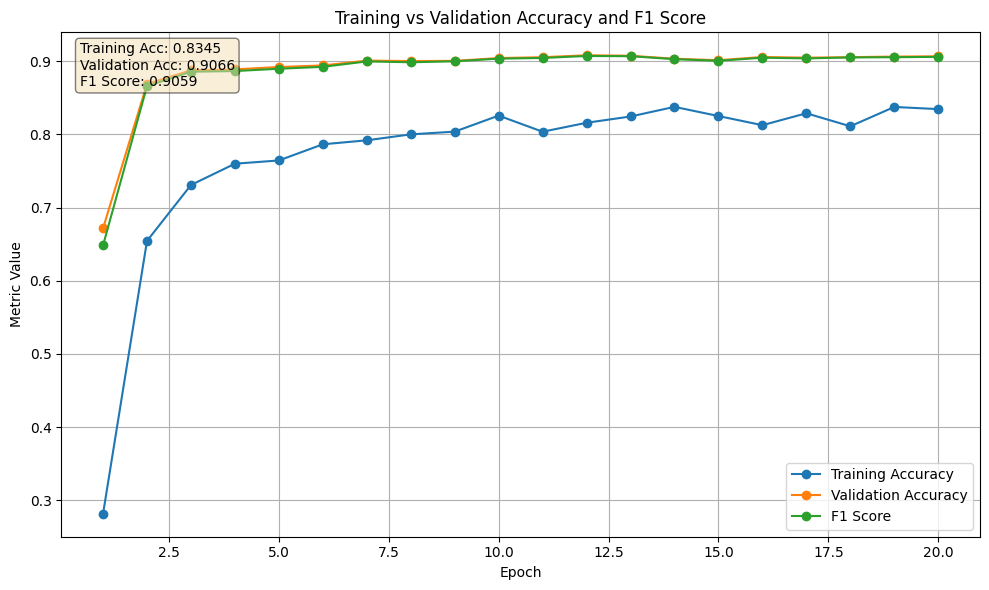

In [ ]:
def main():

    model = EMNISTModel(num_classes=47).to(device)
    train_loader, test_loader = data_loaders()


    mixup_fn = Mixup(
        mixup_alpha=0.22,
        cutmix_alpha=0.62,
        prob=0.8,
        switch_prob=0.5,
        mode='batch',
        label_smoothing=0.1,
        num_classes= 47
    )
    warmup_epochs = 5

    f1_metric = F1Score(task="multiclass", num_classes= 62, average='weighted').to(device)
    optimizer = Lion(model.parameters(), lr=0.0002, weight_decay=0.01)

    warmup_lambda = lambda epoch: float(epoch + 1) / warmup_epochs
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

    cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=8, T_mult=1, eta_min=1e-6)

    scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])
    criterion = nn.KLDivLoss(reduction='batchmean')

    scaler = GradScaler()



    # Training loop
    best_f1 = 0
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer,
            scheduler, scaler, mixup_fn, epoch
        )

        test_loss, test_acc, f1 = validate(model, test_loader, criterion, f1_metric)

        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
              f"F1 Score: {f1:.4f}")




        scheduler.step()



if __name__ == "__main__":
    main()